# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [12]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 3
ROUNDS = 3
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Get IQ data

In [20]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.3

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 255/255 [00:00<00:00, 444.29it/s]

[('000 00 00 00', 5321), ('001 00 01 00', 216), ('010 00 11 00', 208), ('000 01 01 01', 208), ('100 10 00 00', 205), ('000 10 00 00', 205), ('001 01 00 00', 204), ('010 11 00 00', 203), ('001 01 00 01', 198), ('000 10 10 00', 198), ('100 00 10 00', 197), ('100 10 00 10', 195), ('010 11 00 11', 194), ('000 10 10 10', 191), ('000 01 00 00', 187), ('000 01 01 00', 174), ('010 10 01 00', 110), ('100 00 00 00', 104), ('010 01 10 01', 100), ('010 00 00 00', 98), ('001 00 00 00', 94), ('010 01 00 00', 92), ('010 01 10 00', 21), ('011 01 11 01', 19), ('100 00 10 10', 18), ('010 10 11 00', 17), ('110 01 00 01', 17), ('001 00 01 01', 17), ('001 10 11 10', 15), ('000 00 00 10', 15), ('110 00 01 00', 15), ('000 00 01 00', 14), ('110 10 11 00', 14), ('010 00 01 00', 13), ('010 11 00 01', 13), ('000 00 00 01', 13), ('001 11 10 00', 13), ('001 01 01 00', 13), ('011 10 00 00', 13), ('010 10 00 00', 12), ('000 11 11 10', 12), ('000 11 11 00', 12), ('001 11 00 00', 12), ('100 11 01 11', 12), ('101 11 00

# Pickle for other applications

In [21]:
import pickle

with open('IQ_data(7,7,1e4).pkl', 'wb') as f:
    pickle.dump(IQ_data, f)

with open('IQ_data_extreme(7,7,1e4).pkl', 'wb') as f:
    pickle.dump(IQ_data_extreme, f)

with open('qubit_mapping(7,7).pkl', 'wb') as f:
    pickle.dump(simulator.qubit_mapping, f)

# Simulator

# Decode IQ data

In [5]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [28]:
import cpp_soft_info

_DETAILED = True

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_extreme = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 132 out of 10000 shots for _RESETS = False
num_errors EXTREME: 296 out of 10000 shots for _RESETS = False


In [29]:
p_meas = -1
# p_meas = 30e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

matching = pymatching.Matching.from_detector_error_model(model)
result_informed_extreme = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data_extreme[:],
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                             p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_informed_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors: 166 out of 10000 shots for _RESETS = False
num_errors EXTREME: 2397 out of 10000 shots for _RESETS = False


In [30]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)

matching = pymatching.Matching.from_detector_error_model(model)
result_flat_extreme = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data_extreme,
                                                         ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                                            simulator.processed_scaler_dict, _detailed=_DETAILED)

print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_flat_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 196 out of 10000 shots for _RESETS = False
num_errors EXTREME: 3566 out of 10000 shots for _RESETS = False


# Plot the results

In [31]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)
print("\nIQ EXTREME:", result_extreme.indices, "\nFlat EXTREME:", result_flat_extreme.indices, "\nInformed EXTREME", result_informed_extreme.indices)


IQ: [42, 65, 66, 751, 768, 948, 997, 1029, 1049, 1076, 1095, 1198, 1335, 1471, 1578, 1588, 1807, 1889, 1897, 1954, 2115, 2274, 2305, 2327, 2342, 2591, 2640, 2677, 2824, 2850, 2901, 2984, 3015, 3059, 3120, 3137, 3183, 3253, 3316, 3340, 3440, 3467, 3516, 3746, 3844, 3863, 3886, 3896, 3960, 4053, 4268, 4461, 4507, 4592, 4621, 4674, 4693, 4715, 4717, 4749, 4840, 4935, 5052, 5176, 5224, 5258, 5265, 5332, 5365, 5386, 5425, 5723, 5785, 5789, 5848, 5925, 5938, 6095, 6180, 6222, 6234, 6240, 6459, 6526, 6548, 6699, 6841, 6899, 6914, 6953, 6957, 7016, 7157, 7181, 7233, 7371, 7378, 7528, 7657, 7710, 7939, 7974, 8116, 8225, 8502, 8644, 8651, 8677, 8841, 8916, 8987, 8992, 9142, 9156, 9250, 9297, 9336, 9357, 9370, 9378, 9523, 9599, 9634, 9647, 9693, 9744, 9814, 9828, 9850, 9863, 9877, 9879] 
Flat: [5, 42, 65, 66, 136, 616, 698, 751, 767, 768, 776, 948, 1049, 1076, 1095, 1132, 1165, 1283, 1335, 1425, 1471, 1489, 1664, 1889, 1897, 1944, 1954, 2115, 2305, 2337, 2342, 2431, 2443, 2591, 2640, 2761, 2817,

-----IQ True decoding -----


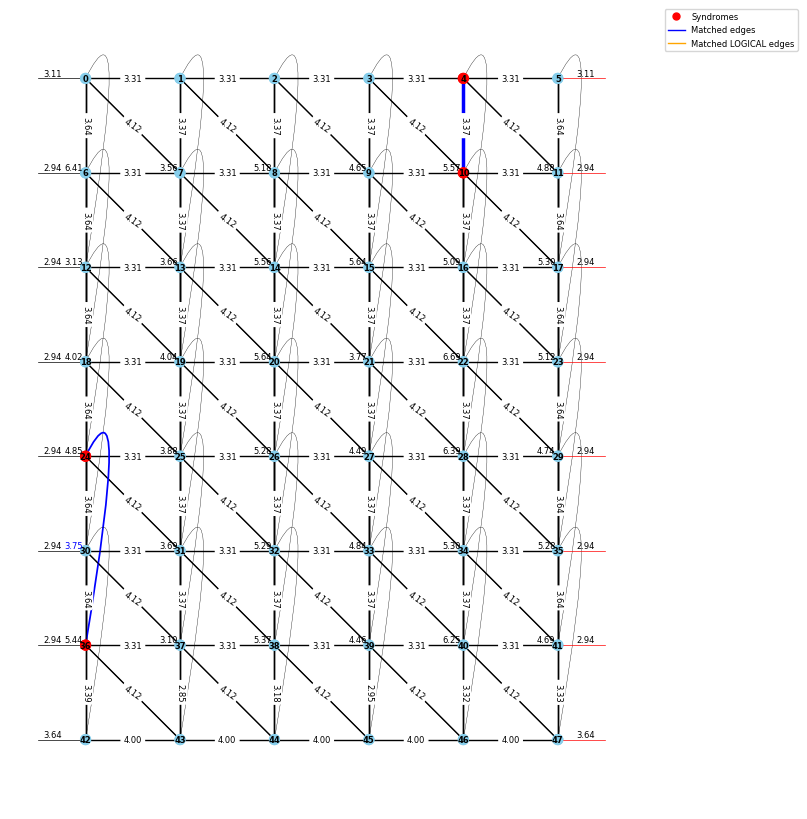

-----flat True decoding-----


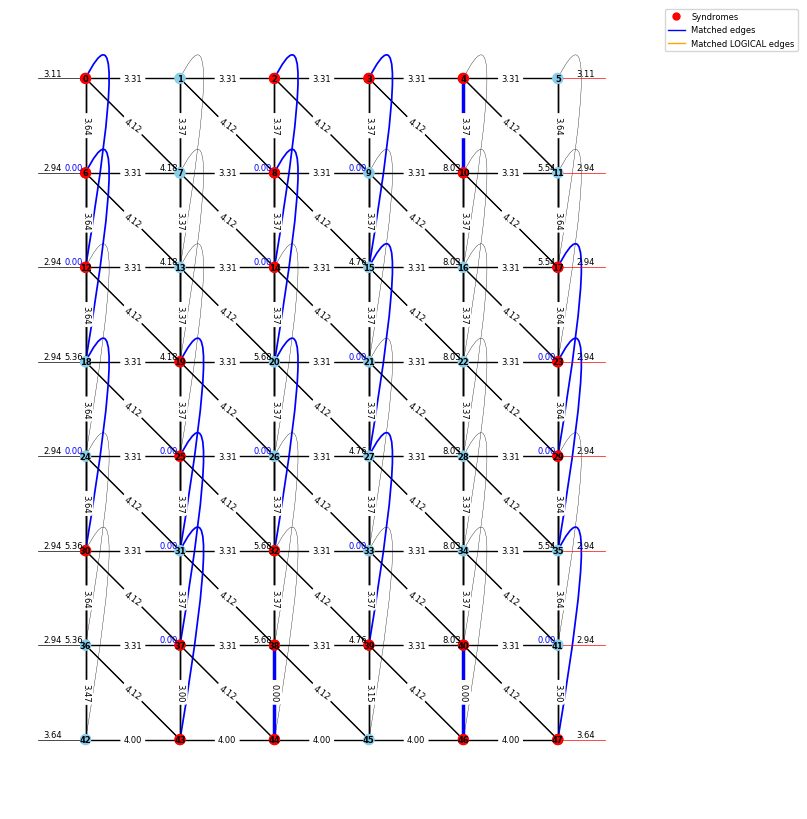

-----INFORMED True decoding-----


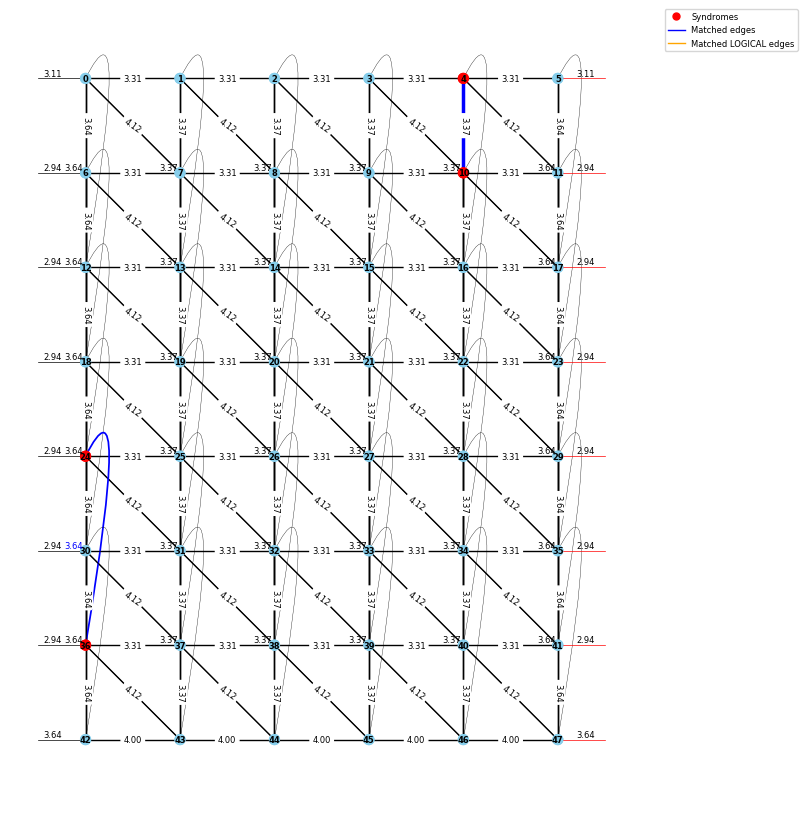

In [35]:
from soft_info import draw_matching_graph


index = 100

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_extreme
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [33]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 60
[458, 764, 767, 901, 934, 1046, 1165, 1195, 1283, 1425, 1562, 1671, 1718, 2411, 2432, 2589, 2729, 2869, 3154, 3161, 3246, 3431, 3536, 4065, 4173, 4300, 4549, 4686, 4953, 5016, 5589, 5630, 6104, 6155, 6320, 6470, 6576, 6763, 6774, 6796, 6959, 7044, 7143, 7349, 7354, 7453, 7614, 8035, 8247, 8326, 8599, 8896, 8954, 9137, 9323, 9491, 9533, 9662, 9773, 9885]
indices that are in IQ but not in informed with len: 26
[751, 997, 1095, 1198, 1889, 2274, 2984, 3059, 3120, 3340, 4053, 4693, 4840, 5224, 5785, 5925, 7974, 8116, 8502, 8644, 8916, 9297, 9336, 9370, 9744, 9877]

indices that are in IQ but not in flat with len: 40
[997, 1029, 1198, 1578, 1588, 1807, 2274, 2327, 2677, 2824, 2901, 2984, 3120, 3137, 3340, 3440, 3863, 3896, 3960, 4053, 4268, 4461, 4693, 4749, 5723, 6548, 6841, 6899, 7528, 8116, 8225, 8502, 8644, 8987, 8992, 9523, 9634, 9647, 9877, 9879]
indices that are in flat but not in IQ with len: 104
[5, 136, 616, 698, 767, 776, 11

# Analyse specific shots

{'0000000 000010 000000 000000 001000 000000 000000 000000': 1}


100%|██████████| 169/169 [00:00<00:00, 2286572.18it/s]

mean time edge weight: 3.4590393702189126

[(4, 16), (27, 15), (18, 30), (21, 33), (24, 25), (26, 38), (46, 45), (47, 35), (46, 47), (34, 41), (36, -1), (42, -1)]
-----IQ-----


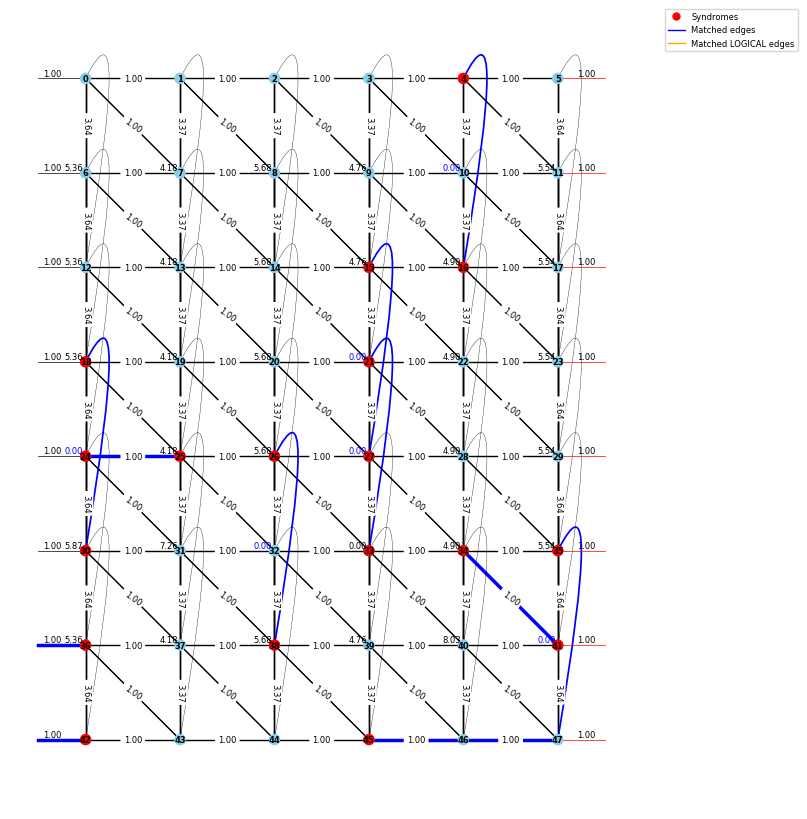

In [12]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)